In [1]:
from IPython.display import display

from notebooks.util.long_memory_utils import *
from liquidity.features import compute_aggregate_features

from market_impact.util.utils import normalize_imbalances

from hurst_exponent.util.utils import augmented_dickey_fuller

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

In [3]:
# Number of events to use
EVENTS_RANGE = 100000

# Lag/window size for Hurst and the ACF
LAG = 100

## Load market orders raw sample data

In [4]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'AAPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')
acf_data_dir = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'long_memory')


stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2017-NEW.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['AAPL']

In [5]:
display(tsla_raw_df)

,Unnamed: 0,event_timestamp,sign,side,lob_action,order_executed,execution_price,size,ask,bid,...,bid_queue_size_mean,midprice_change,R1,spread,date,daily_R1,daily_vol,daily_num,norm_size,signed_volume
0,0,2017-01-03 10:30:19.351489154,1,ASK,UPDATE,True,219.37,1,219.37,219.28,...,135.963741,0.000,0.000,0.09,2017-01-03,0.021159,277786,3279,0.008043,1
1,1,2017-01-03 10:30:19.351537884,1,ASK,REMOVE,True,219.37,15,219.37,219.28,...,135.963741,0.005,0.005,0.09,2017-01-03,0.021159,277786,3279,0.120647,15
2,2,2017-01-03 10:30:19.351549791,1,ASK,UPDATE,True,219.38,80,219.38,219.28,...,135.963741,0.005,0.005,0.10,2017-01-03,0.021159,277786,3279,0.643452,80
3,3,2017-01-03 10:30:19.351601187,1,ASK,UPDATE,True,219.38,80,219.38,219.29,...,135.963741,0.000,0.000,0.09,2017-01-03,0.021159,277786,3279,0.643452,80
4,4,2017-01-03 10:30:19.351702603,1,ASK,REMOVE,True,219.38,40,219.38,219.29,...,135.963741,0.050,0.050,0.09,2017-01-03,0.021159,277786,3279,0.321726,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1411991,3572,2017-12-29 14:59:11.533706465,1,ASK,REMOVE,True,311.06,321,311.06,311.02,...,151.020334,0.025,0.025,0.04,2017-12-29,0.019713,322243,3577,2.112474,321
1411992,3573,2017-12-29 14:59:50.386983509,-1,BID,REMOVE,True,311.03,200,311.10,311.03,...,151.020334,-0.030,0.030,0.07,2017-12-29,0.019713,322243,3577,1.324325,-200
1411993,3574,2017-12-29 14:59:50.387892067,-1,BID,UPDATE,True,311.02,200,311.05,311.02,...,151.020334,0.000,-0.000,0.03,2017-12-29,0.019713,322243,3577,1.324325,-200
1411994,3575,2017-12-29 14:59:50.387904347,-1,BID,UPDATE,True,311.02,2,311.05,311.02,...,151.020334,0.000,-0.000,0.03,2017-12-29,0.019713,322243,3577,0.013243,-2


# The Long Memory of Market Orders (Trades)

To determine if a random process exhibits long memory, we take the following approach:

- **Infer an Autocorrelation Function (ACF):** Start by inferring the ACF from a finite return sample.

- **Fit a Power-law to the ACF:** Use the inferred ACF to fit a power-law.

- **Estimate Hurst Exponent:** Use standard and generalized hurst on cumulative sum of raw series.

## 1. Signed Orderflow

In [6]:
# Signs
signed_orderflow = {
  'TSLA': tsla_raw_df['sign'],
  'MSFT': msft_raw_df['sign'],
  'AMZN': amzn_raw_df['sign'],
  'NFLX': nflx_raw_df['sign'],
  'EBAY': ebay_raw_df['sign'],
  'AAPL': appl_raw_df['sign']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#signed_orderflow = {stock: data.head(EVENTS_RANGE) for stock, data in signed_orderflow.items()}

### Stationarity Test

In [7]:
# ADF test
for stock, data in signed_orderflow.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -31.97
p-value: 0.00,
N: 99933, 
critical values: {'1%': -3.4304154385236156, '5%': -2.8615689228020016, '10%': -2.5667853945954673}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -30.94
p-value: 0.00,
N: 99932, 
critical values: {'1%': -3.430415439178463, '5%': -2.8615689230914305, '10%': -2.566785394749521}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -41.34
p-value: 0.00,
N: 99956, 
critical values: {'1%': -3.430415423465743, '5%': -2.861568916146731, '10%': -2.566785391053087}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -39.10
p-value: 0.00,
N: 99952, 
critical values: {'1%': -3.430415426084006, '5%': -2.8615689173039494, '10%': -2.566785391669036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


EBAY
AD

### 1.1. Signs ACF

In [8]:
# Linear ACF
signs_linear_acf_filename = f"{acf_data_dir}/mo_signs_acfs.pkl"
signs_linear_acfs = compute_acfs(filename=signs_linear_acf_filename, data=signed_orderflow, option='linear')
print(signs_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


In [9]:
# Nonlinear ACF
signs_nonlinear_acf_filename = f"{acf_data_dir}/mo_signs_nonlinear_acfs.pkl"
signs_nonlinear_acfs = compute_acfs(filename=signs_nonlinear_acf_filename, data=signed_orderflow, option='nonlinear')
print(signs_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


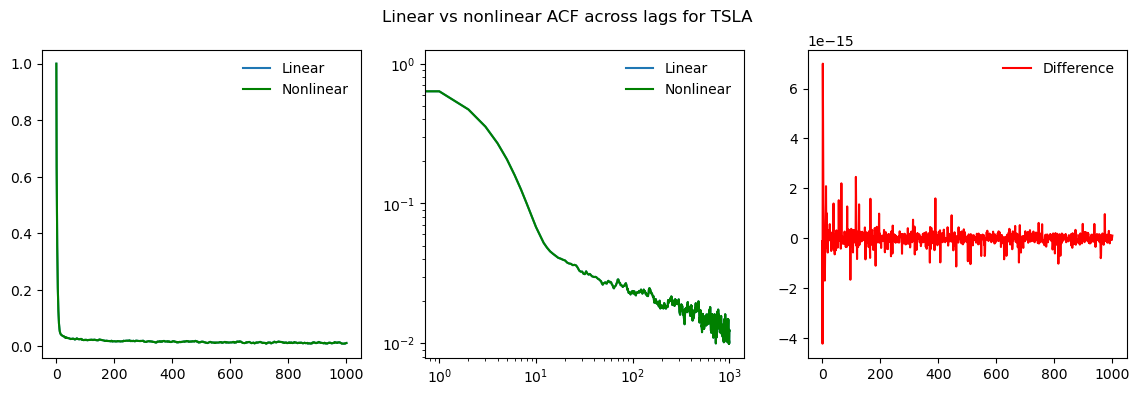

TSLA Max difference: 6.994405055138486e-15


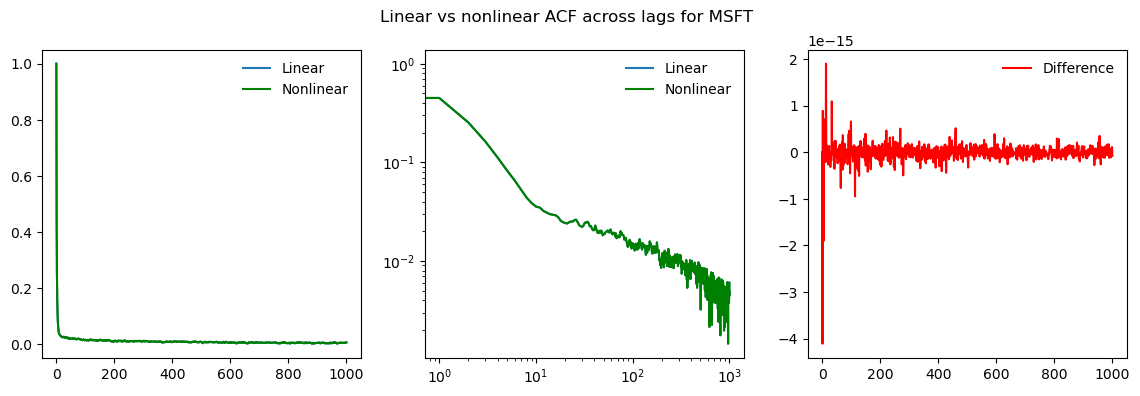

MSFT Max difference: 1.9012569296705806e-15


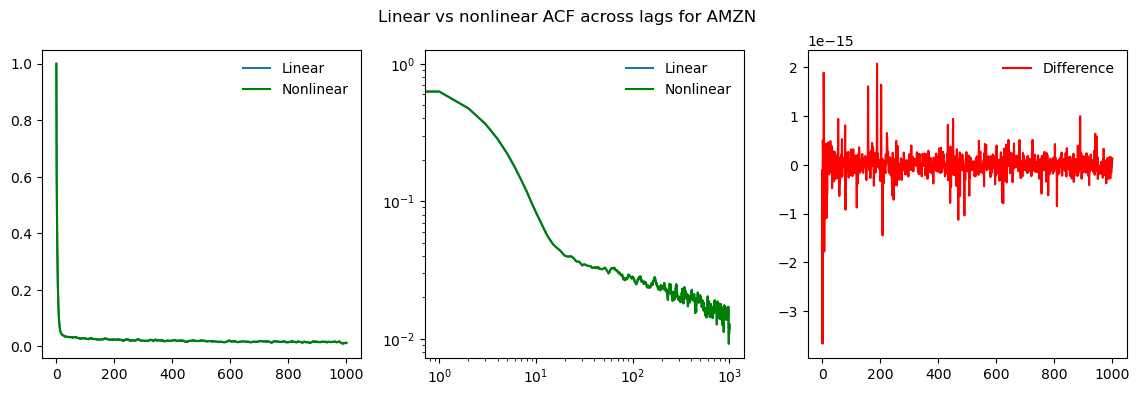

AMZN Max difference: 2.0712598303163077e-15


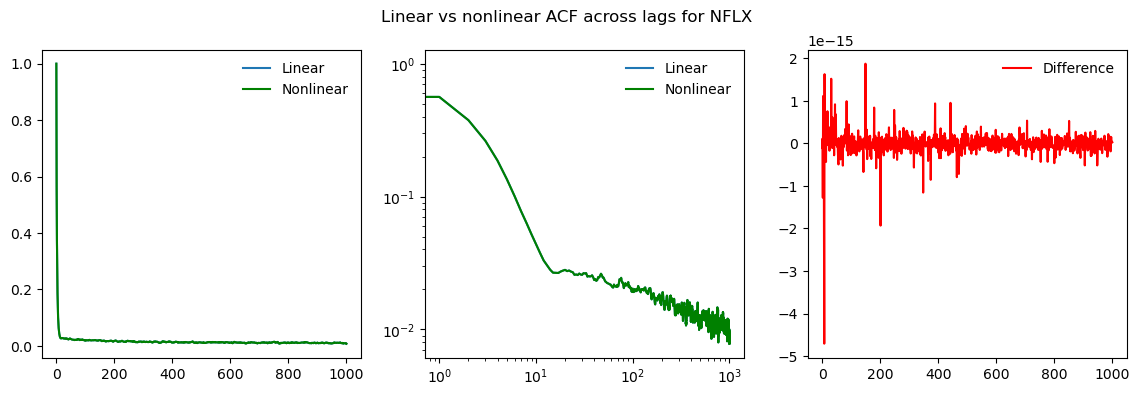

NFLX Max difference: 1.870031907102998e-15


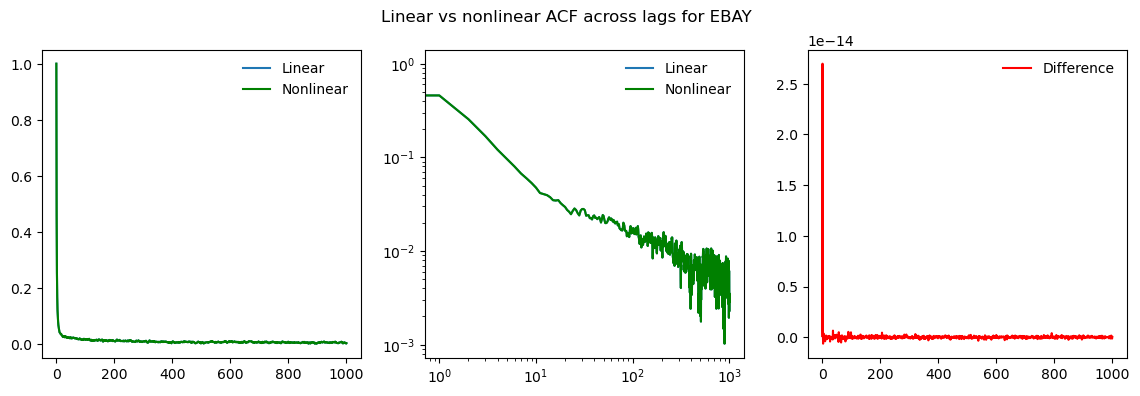

EBAY Max difference: 2.6978419498391304e-14


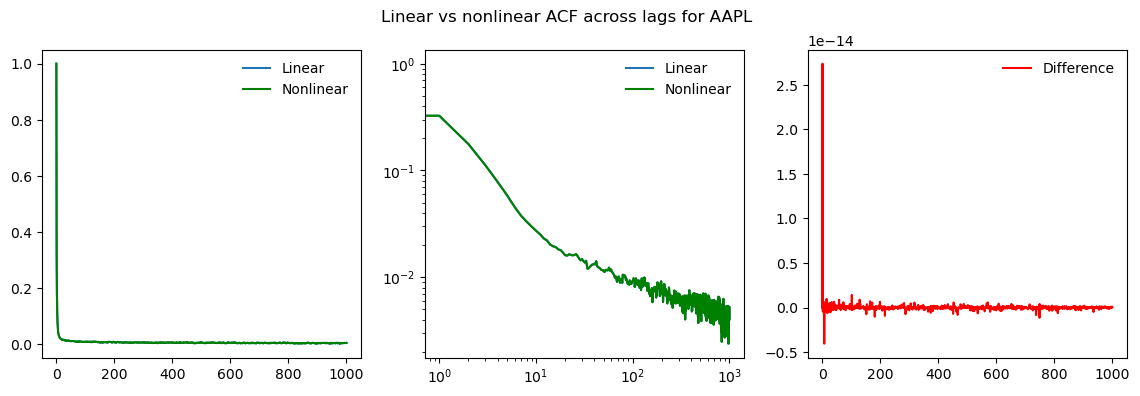

AAPL Max difference: 2.736699755701011e-14


In [10]:
for stock_name in signs_linear_acfs.keys():
    plot_acf_difference(stock_name, signs_linear_acfs, signs_nonlinear_acfs)

### 1.2. Fit power law to ACF

In [11]:
# Load the pre-computed ACFs
signs_acf_values = {}

for stock, data in signs_nonlinear_acfs.items():
    signs_acf_values[stock] = construct_xy(data, stock)

In [12]:
# Using signs_nonlinear_acfs
signs_fit_results_list = []
signs_fit_objects = {}  # Dictionary to store fit objects

for stock, data in signs_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        signs_fit_results_list.append(fit_dict)
        signs_fit_objects[stock] = fit_obj  # Store the fit object

signs_acf_fit_results = pd.DataFrame(signs_fit_results_list)
display(signs_acf_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0958313...",10,11.0,0.142281,-12587.600995,7.868016,0.907512,-0.294655,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1129226...",10,11.0,0.273461,-12870.804260,21.020366,0.913140,-0.448768,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1047762...",10,11.0,0.091826,-12267.384328,6.786243,0.897486,-0.284618,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0683281...",10,11.0,0.137235,-13177.235447,7.461502,0.909748,-0.270980,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1400865...",10,11.0,0.200807,-12596.027283,22.198156,0.906701,-0.482547,EBAY


In [13]:
signs_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])

In [14]:
avg_alpha = signs_acf_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.3571910134515317


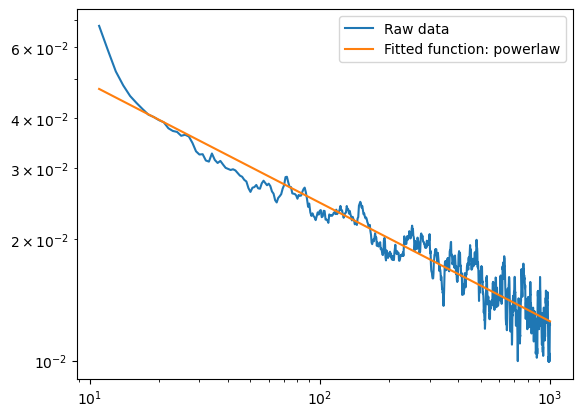

In [15]:
tsla_acf_fit = signs_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

### 1.3. Signed Orderflow Hurst Exponents

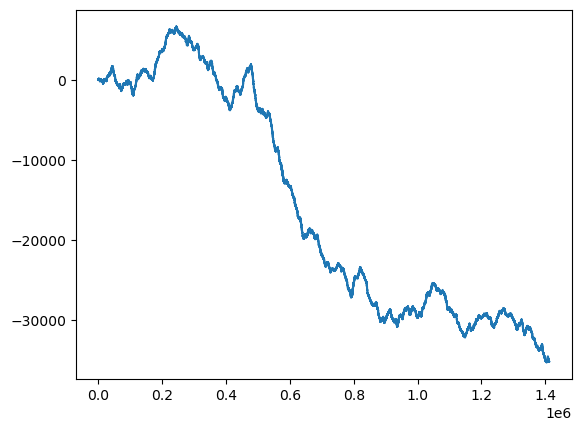

In [16]:
# Compute cumsum of signed orderflow
cumsum_signed_orderflow = {
  'TSLA': tsla_raw_df['sign'].cumsum(),
  'MSFT': msft_raw_df['sign'].cumsum(),
  'AMZN': amzn_raw_df['sign'].cumsum(),
  'NFLX': nflx_raw_df['sign'].cumsum(),
  'EBAY': ebay_raw_df['sign'].cumsum(),
  'AAPL': appl_raw_df['sign'].cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
# cumsum_signed_orderflow = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_signed_orderflow.items()}
tsla_cumsum_signs = tsla_raw_df['sign'].cumsum()
x = list(range(1, len(tsla_cumsum_signs)+1))
plt.plot(x, tsla_cumsum_signs)
plt.grid(False)

#### Standard Hurst

In [17]:
# Standard Hurst
method = 'standard'
signs_fit_results_list = []
signs_fit_objects = {}

for stock, data in cumsum_signed_orderflow.items():
    fit_dict, fit = compute_hurst_exponent('signs', stock, data, method=method)
    if fit_dict:
        signs_fit_results_list.append(fit_dict)
        signs_fit_objects[(stock, method, 'signs')] = fit

signs_std_hurst_fit_results = pd.DataFrame(signs_fit_results_list)
display(signs_std_hurst_fit_results.head(10))

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.4753102...",97,9.0,0.010999,-6463.592838,0.257420,0.999936,0.646010,TSLA,signs
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.1535161...",1,1.0,0.019982,-5619.082309,0.821302,0.999826,0.649338,MSFT,signs
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.4654750...",89,9.0,0.011089,-5472.800991,0.302902,0.999910,0.654103,AMZN,signs
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.3372246...",36,4.0,0.020110,-5541.112633,0.574656,0.999835,0.640755,NFLX,signs
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.1602491...",1,1.0,0.020086,-3656.428058,0.722843,0.999863,0.656713,EBAY,signs
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.1167142...",1,1.0,0.019741,-10048.665967,0.539278,0.999919,0.623785,AAPL,signs


In [18]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = signs_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.6451172464366686


#### Generalized Hurst

In [19]:
# Generalized Hurst
method = 'generalized'
signs_fit_results_list = []
signs_fit_objects = {}

for stock, data in cumsum_signed_orderflow.items():
    fit_dict, fit = compute_hurst_exponent('signs', stock, data, method=method)
    if fit_dict:
        signs_fit_results_list.append(fit_dict)
        signs_fit_objects[(stock, method, 'signs')] = fit

signs_gen_hurst_fit_results = pd.DataFrame(signs_fit_results_list)
display(signs_gen_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.2941371...",49,5.0,0.010536,-6263.355322,0.477687,0.999864,0.627901,TSLA,signs
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.9895156...",1,1.0,0.019982,-5722.900278,0.869110,0.999734,0.628927,MSFT,signs
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.2913578...",45,5.0,0.010618,-5226.597174,0.585070,0.999799,0.633962,AMZN,signs
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.1483010...",1,1.0,0.020372,-5349.342123,1.082023,0.999673,0.624356,NFLX,signs
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.9984007...",1,1.0,0.011478,-3759.999942,0.732262,0.999801,0.635414,EBAY,signs


In [20]:
# Generalized Hurst statistic across stocks
min_hurst_gen = signs_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = signs_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = signs_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = signs_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.6110181481506565
Max Generalized Hurst: 0.6354137636393902
Average Generalized Hurst: 0.6269295435526422
Standard_dev Generalized Hurst: 0.008788222128564505


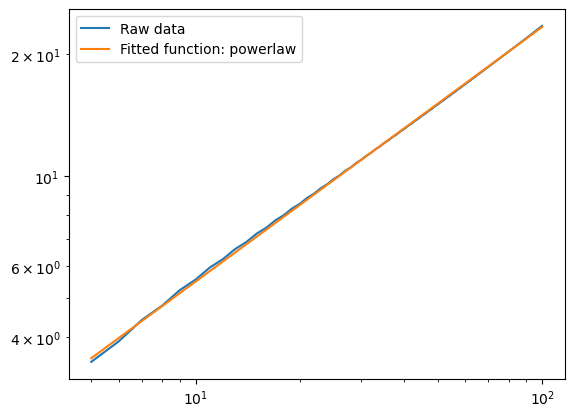

In [21]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = signs_fit_objects[('TSLA', 'generalized', 'signs')]
tsla_generalized_fit.powerlaw.plot_fit()

## 2. Size/ Volume

In [22]:
# Order size/ volume
size_volume = {'TSLA': tsla_raw_df['norm_size'],
               'MSFT': amzn_raw_df['norm_size'],
               'AMZN': nflx_raw_df['norm_size'],
               'NFLX': msft_raw_df['norm_size'],
               'EBAY': ebay_raw_df['norm_size'],
               'AAPL': appl_raw_df['norm_size'],
               }

# Order signed volume
signed_volume = {'TSLA': tsla_raw_df['signed_volume'],
               'MSFT': amzn_raw_df['signed_volume'],
               'AMZN': nflx_raw_df['signed_volume'],
               'NFLX': msft_raw_df['signed_volume'],
               'EBAY': ebay_raw_df['signed_volume'],
               'AAPL': appl_raw_df['signed_volume'],
               }
# Update the dictionary to only keep the first EVENTS_RANGE items
#size_volume = {stock: data.head(EVENTS_RANGE) for stock, data in size_volume.items()}

#### Stationarity Test

In [23]:
# ADF test
for stock, data in signed_volume.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -34.11
p-value: 0.00,
N: 99942, 
critical values: {'1%': -3.4304154326305794, '5%': -2.8615689201974006, '10%': -2.5667853932091242}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -86.38
p-value: 0.00,
N: 99990, 
critical values: {'1%': -3.430415401218969, '5%': -2.861568906314114, '10%': -2.56678538581951}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -73.76
p-value: 0.00,
N: 99986, 
critical values: {'1%': -3.4304154038354513, '5%': -2.8615689074705455, '10%': -2.5667853864350403}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -65.86
p-value: 0.00,
N: 99982, 
critical values: {'1%': -3.430415406452143, '5%': -2.8615689086270693, '10%': -2.56678538705062}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


EBAY
AD

### 2.1. Size/volume ACF

In [24]:
# Linear ACF
volume_linear_acf_filename = f"{acf_data_dir}/mo_volume_linear_acfs.pkl"
volume_linear_acfs = compute_acfs(filename=volume_linear_acf_filename, data=signed_volume, option='linear')
print(volume_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


In [25]:
# Nonlinear ACF
volume_nonlinear_acf_filename = f"{acf_data_dir}/mo_volume_nonlinear_acfs.pkl"
volume_nonlinear_acfs = compute_acfs(filename=volume_nonlinear_acf_filename, data=signed_volume, option='nonlinear')
print(volume_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


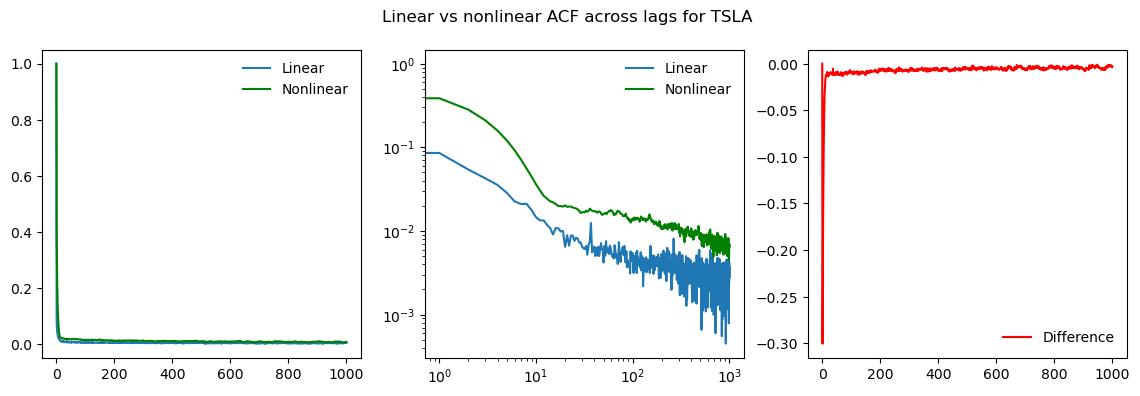

TSLA Max difference: 0.0


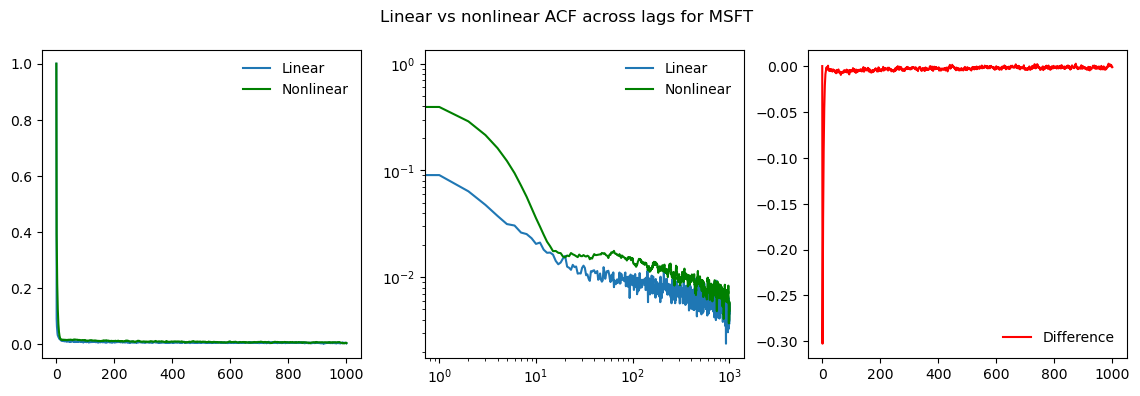

MSFT Max difference: 0.0026398738815948163


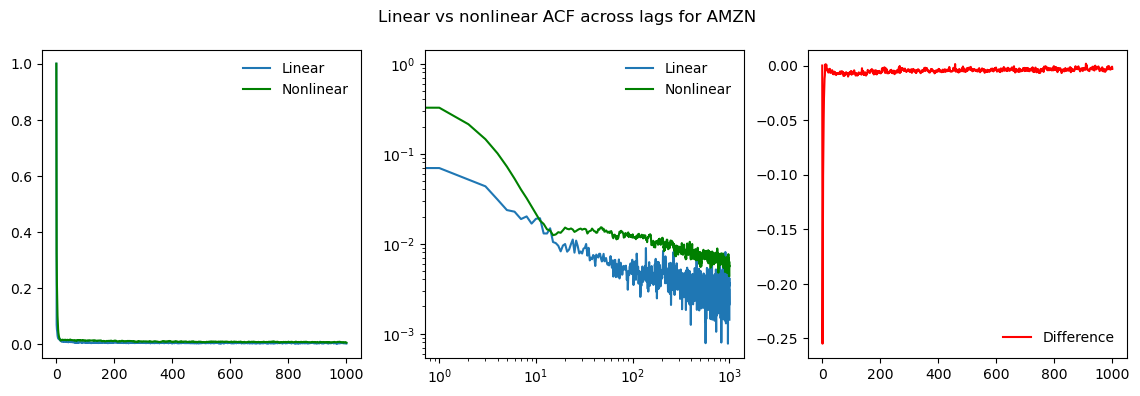

AMZN Max difference: 0.0016886391608425715


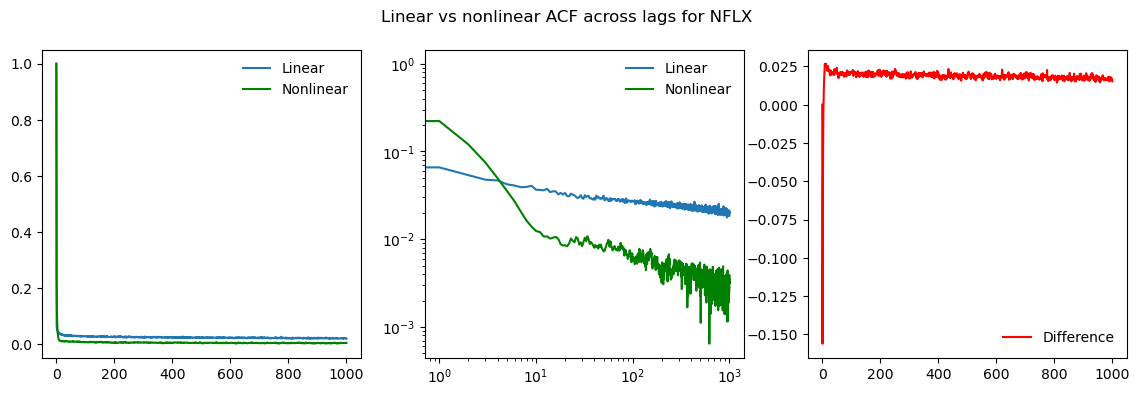

NFLX Max difference: 0.02679866459057618


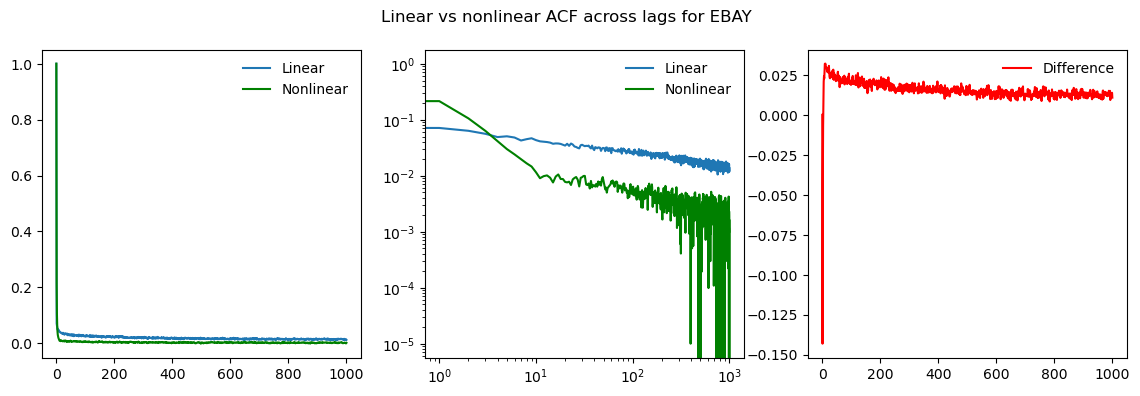

EBAY Max difference: 0.032004427186448026


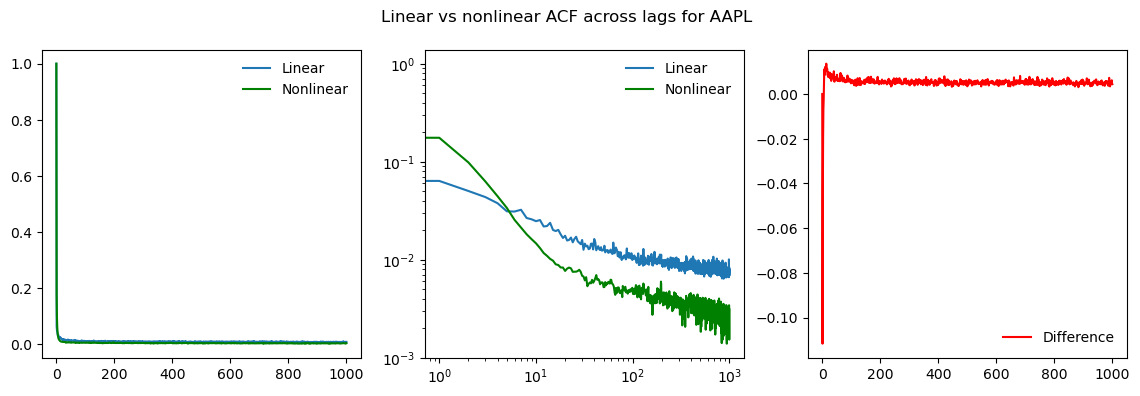

AAPL Max difference: 0.01356089385101963


In [26]:
for stock_name in volume_linear_acfs.keys():
    plot_acf_difference(stock_name, volume_linear_acfs, volume_nonlinear_acfs)

### 2.2. Fit power law to ACF

In [27]:
# Load the pre-computed ACFs
volume_acf_values = {}

for stock, data in volume_nonlinear_acfs.items():
    volume_acf_values[stock] = construct_xy(data, stock)

In [28]:
# Using volume_nonlinear_acfs
volume_fit_results_list = []
volume_fit_objects = {}  # Dictionary to store fit objects

for stock, data in volume_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        volume_fit_results_list.append(fit_dict)
        volume_fit_objects[stock] = fit_obj  # Store the fit object

volume_fit_results = pd.DataFrame(volume_fit_results_list)
display(volume_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0717162...",7,8.0,0.156942,-12452.927155,9.901861,0.809624,-0.345404,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0634937...",7,8.0,0.099598,-12237.238478,9.624010,0.743604,-0.324285,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0436232...",6,7.0,0.128643,-12982.005684,8.362207,0.772951,-0.282674,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0381814...",5,6.0,0.168675,-13721.944035,17.337443,0.801802,-0.381668,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0516643...",4,5.0,0.211635,-13198.256422,99.062466,0.734903,-0.494852,EBAY


In [29]:
volume_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])

In [30]:
avg_alpha = volume_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.35879006385015466


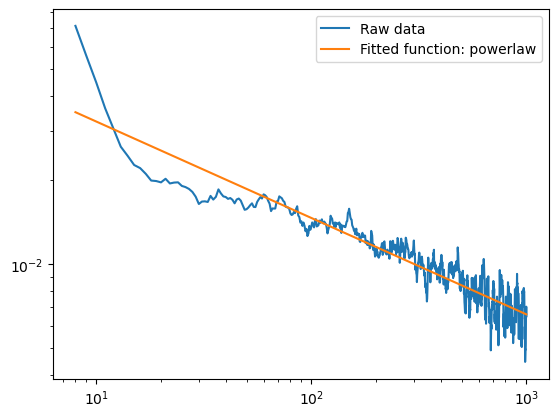

In [31]:
tsla_acf_fit = volume_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

### 2.3. Size/ Volume Hurst Exponents

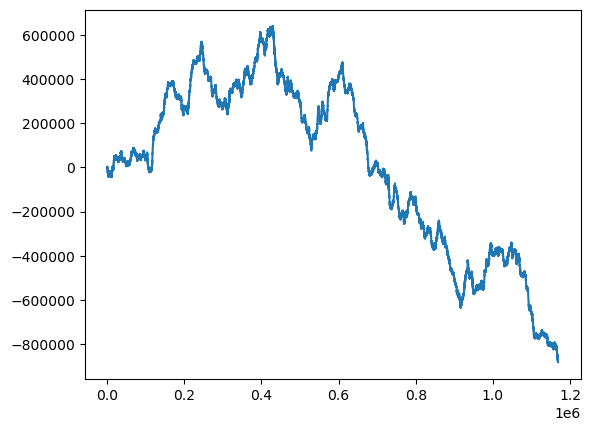

In [32]:
# Compute cumsum of size/volumes
cumsum_size_volume = {
               'TSLA': tsla_raw_df['norm_size'].cumsum(),
               'MSFT': amzn_raw_df['norm_size'].cumsum(),
               'AMZN': nflx_raw_df['norm_size'].cumsum(),
               'NFLX': msft_raw_df['norm_size'].cumsum(),
               'EBAY': ebay_raw_df['norm_size'].cumsum(),
               'AAPL': appl_raw_df['norm_size'].cumsum()
               }

cumsum_signed_volume = {
               'TSLA': tsla_raw_df['signed_volume'].cumsum(),
               'MSFT': amzn_raw_df['signed_volume'].cumsum(),
               'AMZN': nflx_raw_df['signed_volume'].cumsum(),
               'NFLX': msft_raw_df['signed_volume'].cumsum(),
               'EBAY': ebay_raw_df['signed_volume'].cumsum(),
               'AAPL': appl_raw_df['signed_volume'].cumsum()
               }
# Update the dictionary to only keep the first EVENTS_RANGE items
#cumsum_size_volume = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_size_volume.items()}
tsla_cumsum_volume = amzn_raw_df['signed_volume'].cumsum()
x = list(range(1, len(tsla_cumsum_volume)+1))
plt.plot(x, tsla_cumsum_volume)
plt.grid(False)
plt.show()

#### Standard Hurst

In [33]:
# Standard Hurst
method = 'standard'
volume_fit_results_list = []
volume_fit_objects = {}

for stock, data in cumsum_signed_volume.items():
    fit_dict, fit = compute_hurst_exponent('volume', stock, data, method=method)
    if fit_dict:
        volume_fit_results_list.append(fit_dict)
        volume_fit_objects[(stock, method, 'volume')] = fit

volume_std_hurst_fit_results = pd.DataFrame(volume_fit_results_list)
display(volume_std_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:94: UserWarning: Hurst exponent not in a valid range (0, 1).
  warnings.warn("Hurst exponent not in a valid range (0, 1).")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:94: UserWarning: Hurst exponent not in a valid range (0, 1).
  warnings.warn("Hurst exponent not in a valid range (0, 1).")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 367.60610...",1185,99.0,0.666667,12.173224,9.556174e-02,1.171048e+00,0.530904,TSLA,volume
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 162.60106...",1071,99.0,0.900000,5.762968,2.447381e-02,9.558062e-01,0.596950,MSFT,volume
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1063.7943...",1127,99.0,0.666667,9.398747,5.098346e-02,1.152082e+00,0.324926,AMZN,volume
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 602.16476...",1099,99.0,0.666667,17.044141,8.587345e-02,1.114243e+00,0.624436,NFLX,volume
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 3.6310567...",689,98.0,1.000000,836.816470,1.183867e+18,-1.226635e+37,21.279852,EBAY,volume


In [34]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = volume_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 4.1921253827985385


In [35]:
display(volume_fit_objects.keys())

dict_keys([('TSLA', 'standard', 'volume'), ('MSFT', 'standard', 'volume'), ('AMZN', 'standard', 'volume'), ('NFLX', 'standard', 'volume'), ('EBAY', 'standard', 'volume'), ('AAPL', 'standard', 'volume')])

#### Generalized Hurst

In [36]:
# Generalized Hurst
method = 'generalized'
volume_fit_results_list = []
volume_fit_objects = {}

for stock, data in cumsum_signed_volume.items():
    fit_dict, fit = compute_hurst_exponent('volume', stock, data, method=method)
    if fit_dict:
        volume_fit_results_list.append(fit_dict)
        volume_fit_objects[(stock, method, 'volume')] = fit

volume_gen_hurst_fit_results = pd.DataFrame(volume_fit_results_list)
display(volume_gen_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 126.67418...",1021,86.0,0.071856,-908.743454,0.001733,0.999999,0.688335,TSLA,volume
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 76.403494...",885,82.0,0.056122,-662.343226,0.008565,0.999993,0.689900,MSFT,volume
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 118.63870...",1051,93.0,0.151899,-580.928710,0.000649,1.000000,0.710195,AMZN,volume
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 323.50121...",1014,92.0,0.125000,-504.539742,0.000655,1.000000,0.682365,NFLX,volume
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 371.35071...",607,87.0,0.076923,-419.346328,0.001233,1.000000,0.631559,EBAY,volume


In [37]:
# Generalized Hurst statistic across stocks
min_hurst_gen = volume_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = volume_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = volume_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = volume_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.6315588442196232
Max Generalized Hurst: 0.7101946947504961
Average Generalized Hurst: 0.6825388391282371
Standard_dev Generalized Hurst: 0.026677890726284032


In [38]:
print(volume_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'volume'), ('MSFT', 'generalized', 'volume'), ('AMZN', 'generalized', 'volume'), ('NFLX', 'generalized', 'volume'), ('EBAY', 'generalized', 'volume'), ('AAPL', 'generalized', 'volume')])


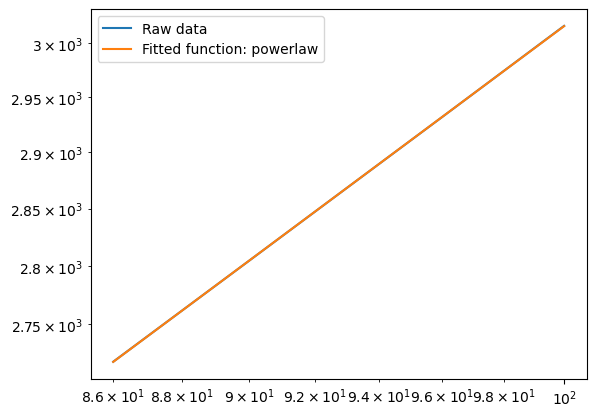

In [39]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = volume_fit_objects[('TSLA', 'generalized', 'volume')]
tsla_generalized_fit.powerlaw.plot_fit()

## 3. Signed Ordeflow Imbalance

In [40]:
# Aggregate orderflow
tsla_aggregate_orderflow = compute_aggregate_features(tsla_raw_df, [LAG])
msft_aggregate_orderflow = compute_aggregate_features(msft_raw_df, [LAG])
amzn_aggregate_orderflow = compute_aggregate_features(amzn_raw_df, [LAG])
nflx_aggregate_orderflow = compute_aggregate_features(nflx_raw_df, [LAG])
ebay_aggregate_orderflow = compute_aggregate_features(ebay_raw_df, [LAG])
appl_aggregate_orderflow = compute_aggregate_features(appl_raw_df, [LAG])

# Normalize imblances
tsla_aggregate_orderflow = normalize_imbalances(tsla_aggregate_orderflow)
msft_aggregate_orderflow = normalize_imbalances(msft_aggregate_orderflow)
amzn_aggregate_orderflow = normalize_imbalances(amzn_aggregate_orderflow)
nflx_aggregate_orderflow = normalize_imbalances(nflx_aggregate_orderflow)
ebay_aggregate_orderflow = normalize_imbalances(ebay_aggregate_orderflow)
appl_aggregate_orderflow = normalize_imbalances(appl_aggregate_orderflow)

# Order Sign imbalance
sign_imbalance = {
  'TSLA': tsla_aggregate_orderflow['sign_imbalance'],
  'MSFT': msft_aggregate_orderflow['sign_imbalance'],
  'AMZN': amzn_aggregate_orderflow['sign_imbalance'],
  'NFLX': nflx_aggregate_orderflow['sign_imbalance'],
  'EBAY': ebay_aggregate_orderflow['sign_imbalance'],
  'AAPL': appl_aggregate_orderflow['sign_imbalance']
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#sign_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in sign_imbalance.items()}


# Sign Volume Imbalance
volume_imbalance = {
 'TSLA': tsla_aggregate_orderflow['volume_imbalance'],
 'MSFT': msft_aggregate_orderflow['volume_imbalance'],
 'AMZN': amzn_aggregate_orderflow['volume_imbalance'],
 'NFLX': nflx_aggregate_orderflow['volume_imbalance'],
 'EBAY': ebay_aggregate_orderflow['volume_imbalance'],
 'AAPL': appl_aggregate_orderflow['volume_imbalance']
}
#volume_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in volume_imbalance.items()}

#### Stationarity Test

In [41]:
# Sign imbalance ADF test
for stock, data in sign_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -15.87
p-value: 0.00,
N: 14093, 
critical values: {'1%': -3.4308140950463146, '5%': -2.8617451089643398, '10%': -2.5668791747192796}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -21.21
p-value: 0.00,
N: 12131, 
critical values: {'1%': -3.4308891710714207, '5%': -2.861778286150791, '10%': -2.566896834684323}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -18.38
p-value: 0.00,
N: 11675, 
critical values: {'1%': -3.430910234548674, '5%': -2.8617875942568736, '10%': -2.5669017893447172}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -19.53
p-value: 0.00,
N: 12766, 
critical values: {'1%': -3.4308623464974426, '5%': -2.861766432078013, '10%': -2.566890524834529}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


EBAY


In [42]:
# Volume imbalance ADF test
for stock, data in volume_imbalance.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -15.46
p-value: 0.00,
N: 14084, 
critical values: {'1%': -3.430814391667804, '5%': -2.861745240047336, '10%': -2.5668792444934807}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -19.43
p-value: 0.00,
N: 12131, 
critical values: {'1%': -3.4308891710714207, '5%': -2.861778286150791, '10%': -2.566896834684323}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -19.32
p-value: 0.00,
N: 11674, 
critical values: {'1%': -3.430910282549172, '5%': -2.8617876154685726, '10%': -2.566901800635616}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -18.85
p-value: 0.00,
N: 12762, 
critical values: {'1%': -3.4308625071147776, '5%': -2.8617665030568897, '10%': -2.566890562616092}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


EBAY
AD

### 3.1. Order sign imbalance long memory

In [43]:
# Linear ACF
sign_imbalance_linear_acf_filename = f"{acf_data_dir}/mo_sign_imbalance_linear_acfs.pkl"
sign_imbalance_linear_acfs = compute_acfs(filename=sign_imbalance_linear_acf_filename, data=sign_imbalance, option='linear')
print(sign_imbalance_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


In [44]:
# Nonlinear ACF
sign_imbalance_nonlinear_acf_filename = f"{acf_data_dir}/mo_sign_imbalance_nonlinear_acfs.pkl"
sign_imbalance_nonlinear_acfs = compute_acfs(filename=sign_imbalance_nonlinear_acf_filename, data=sign_imbalance, option='nonlinear')
print(sign_imbalance_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


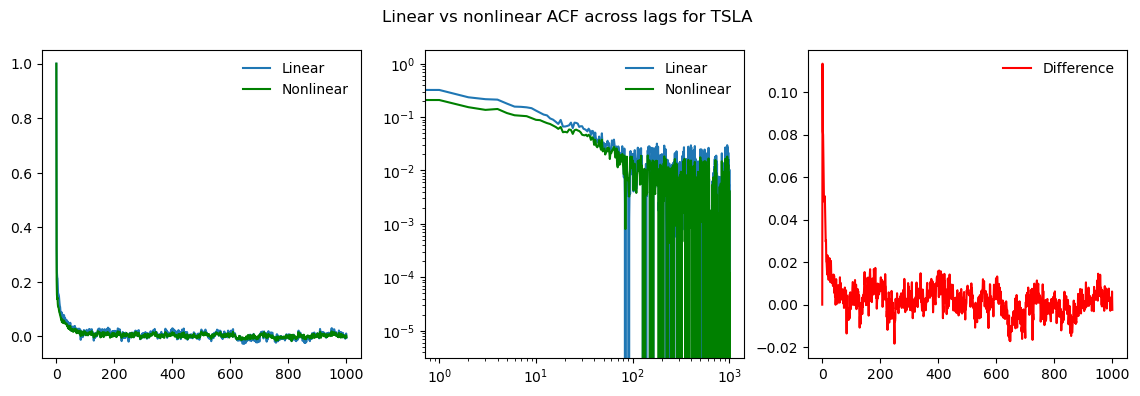

TSLA Max difference: 0.11338497202561168


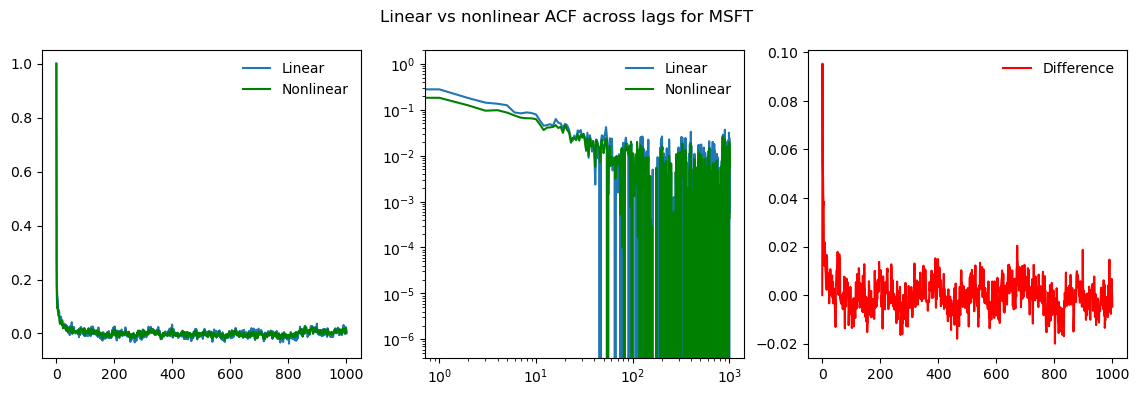

MSFT Max difference: 0.09535673716471998


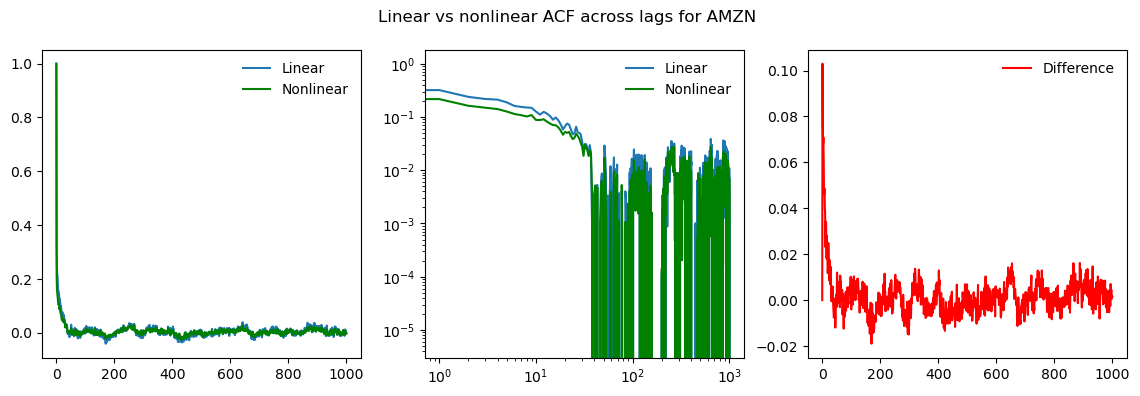

AMZN Max difference: 0.10299711053539962


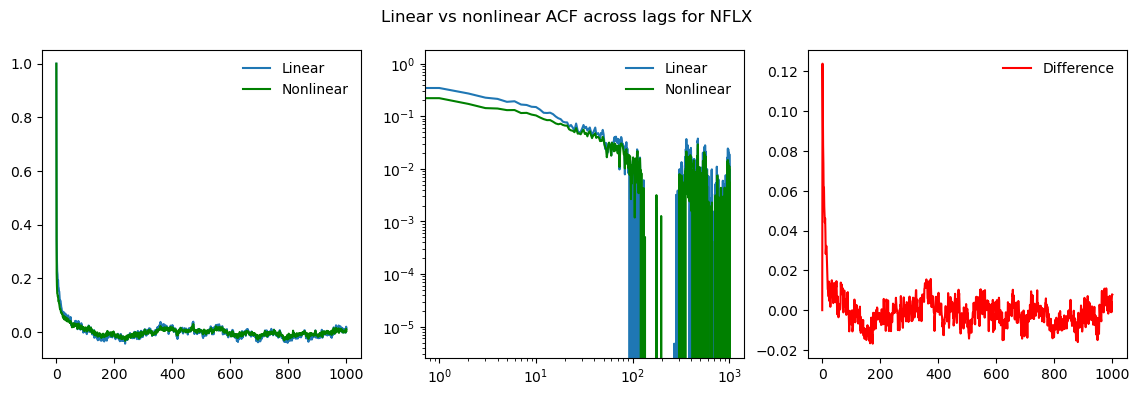

NFLX Max difference: 0.12386907234239689


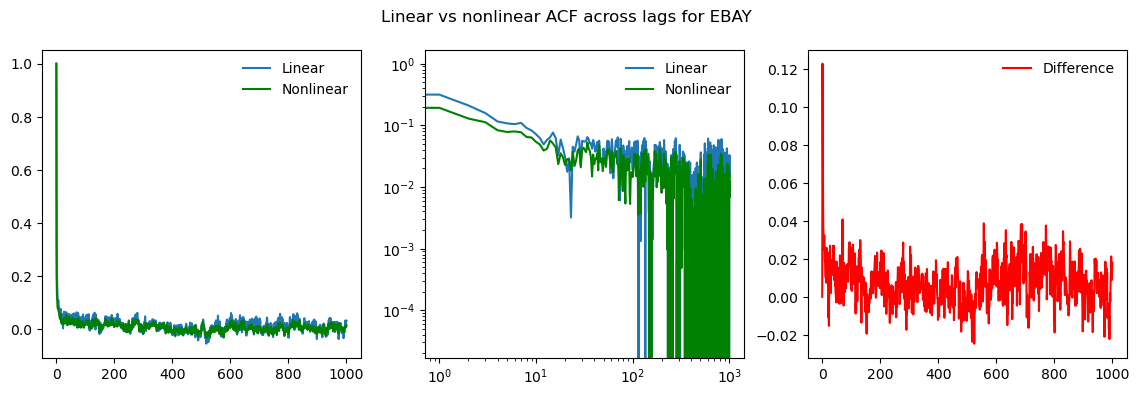

EBAY Max difference: 0.1228659185215484


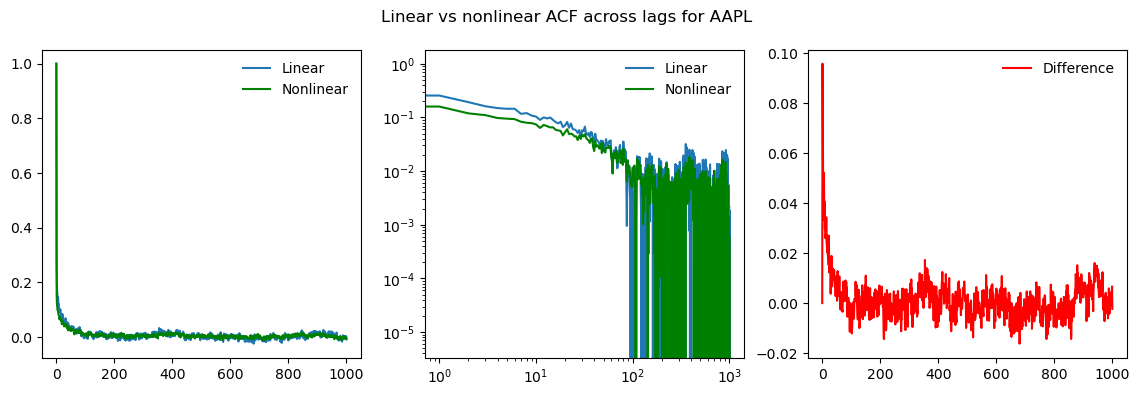

AAPL Max difference: 0.09592032447979285


In [45]:
for stock_name in sign_imbalance_linear_acfs.keys():
    plot_acf_difference(stock_name, sign_imbalance_linear_acfs, sign_imbalance_nonlinear_acfs)

#### 3.1.1. Fit power law to ACF

In [46]:
# Load the pre-computed ACFs
sign_imbalance_acf_values = {}

for stock, data in sign_imbalance_nonlinear_acfs.items():
    sign_imbalance_acf_values[stock] = construct_xy(data, stock)

In [47]:
# Using signs_imbalance_nonlinear_acfs
sign_imbalance_fit_results_list = []
sign_imbalance_fit_objects = {}  # Dictionary to store fit objects

for stock, data in sign_imbalance_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        sign_imbalance_fit_results_list.append(fit_dict)
        sign_imbalance_fit_objects[stock] = fit_obj  # Store the fit object

sign_imbalance_fit_results = pd.DataFrame(sign_imbalance_fit_results_list)
display(sign_imbalance_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.0854227...",10,11.0,0.390515,-10077.206297,285.889878,0.741451,-0.971654,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.4494081...",10,11.0,0.533804,-9449.012259,230.300166,0.324460,-1.279179,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 5.3938756...",10,11.0,0.421796,-9248.365701,164.389614,0.426269,-1.604442,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -2.233885...",10,11.0,0.405651,-8147.296810,306.105615,0.049477,1.510360,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.3087172...",10,11.0,0.408678,-8670.037998,223.333495,0.293214,-0.651992,EBAY


In [48]:
print(sign_imbalance_fit_objects.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


In [49]:
avg_alpha = sign_imbalance_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.6549061323982192


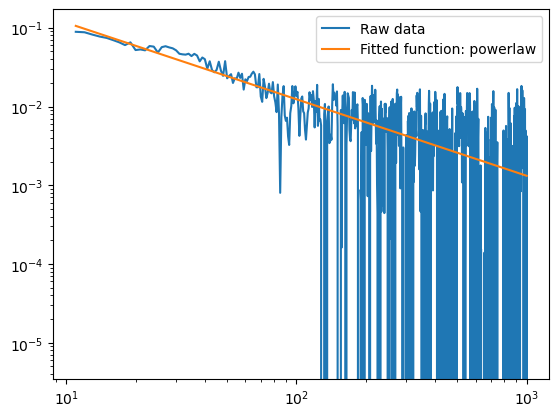

In [50]:
tsla_acf_fit = sign_imbalance_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

#### 3.1.2. Sign Imbalance Hurst Exponents

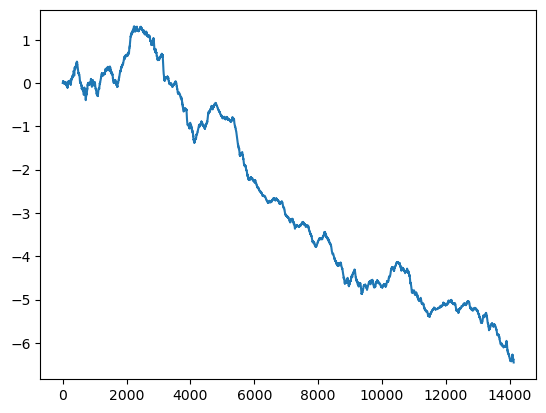

In [51]:
# Compute cumsum of order sign imbalance
cumsum_sign_imbalance = {
  'TSLA': tsla_aggregate_orderflow['sign_imbalance'].cumsum(),
  'MSFT': msft_aggregate_orderflow['sign_imbalance'].cumsum(),
  'AMZN': amzn_aggregate_orderflow['sign_imbalance'].cumsum(),
  'NFLX': nflx_aggregate_orderflow['sign_imbalance'].cumsum(),
  'EBAY': ebay_aggregate_orderflow['sign_imbalance'].cumsum(),
  'AAPL': appl_aggregate_orderflow['sign_imbalance'].cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
# cumsum_sign_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_sign_imbalance.items()}
tsla_cumsum_sign_imbalance = tsla_aggregate_orderflow['sign_imbalance'].cumsum()
x = list(range(1, len(tsla_cumsum_sign_imbalance)+1))
plt.plot(x, tsla_cumsum_sign_imbalance)
plt.grid(False)
plt.show()

##### Standard Hurst

In [52]:
# Standard Hurst
method = 'standard'
sign_imbalance_fit_results_list = []
sign_imbalance_fit_objects = {}

for stock, data in cumsum_sign_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('sign_imbalance', stock, data, method=method)
    if fit_dict:
        sign_imbalance_fit_results_list.append(fit_dict)
        sign_imbalance_fit_objects[(stock, method, 'signs_imbalance')] = fit

sign_imbalance_std_hurst_fit_results = pd.DataFrame(sign_imbalance_fit_results_list)
display(sign_imbalance_std_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0057976...",1,1.0,0.042735,-1380.867443,2.315813,0.996306,0.722459,TSLA,sign_imbalance
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0056547...",1,1.0,0.027523,-1378.569679,1.874222,0.997214,0.671528,MSFT,sign_imbalance
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0089428...",1,1.0,0.046729,-1179.257004,4.467608,0.993198,0.651222,AMZN,sign_imbalance
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0058461...",1,1.0,0.026786,-1345.254116,2.196044,0.997049,0.722048,NFLX,sign_imbalance
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0125421...",1,2.0,0.044118,-660.379472,2.697417,0.994376,0.732925,EBAY,sign_imbalance


In [53]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = sign_imbalance_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.7053177352513161


##### Generalized Hurst

In [54]:
# Generalized Hurst
method = 'generalized'
sign_imbalance_fit_results_list = []
sign_imbalance_fit_objects = {}

for stock, data in cumsum_sign_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('signed_imbalance', stock, data, method=method)
    if fit_dict:
        sign_imbalance_fit_results_list.append(fit_dict)
        sign_imbalance_fit_objects[(stock, method, 'signed_imbalance')] = fit

sign_imbalance_gen_hurst_fit_results = pd.DataFrame(sign_imbalance_fit_results_list)
display(sign_imbalance_gen_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0040501...",1,1.0,0.017094,-1788.409501,0.953559,0.999829,0.753741,TSLA,signed_imbalance
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0040833...",1,1.0,0.018349,-1625.887424,1.542083,0.999530,0.687115,MSFT,signed_imbalance
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0067466...",1,1.0,0.037383,-1337.608323,3.655316,0.997609,0.664282,AMZN,signed_imbalance
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0040286...",1,1.0,0.017857,-1757.943429,0.843864,0.999885,0.752764,NFLX,signed_imbalance
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0091528...",1,2.0,0.014706,-941.074636,0.827712,0.999826,0.731041,EBAY,signed_imbalance


In [55]:
# Generalized Hurst statistic across stocks
min_hurst_gen = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = sign_imbalance_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.6642815086775584
Max Generalized Hurst: 0.7537413297016642
Average Generalized Hurst: 0.7235746058825665
Standard_dev Generalized Hurst: 0.03872902336697893


In [56]:
print(sign_imbalance_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'signed_imbalance'), ('MSFT', 'generalized', 'signed_imbalance'), ('AMZN', 'generalized', 'signed_imbalance'), ('NFLX', 'generalized', 'signed_imbalance'), ('EBAY', 'generalized', 'signed_imbalance'), ('AAPL', 'generalized', 'signed_imbalance')])


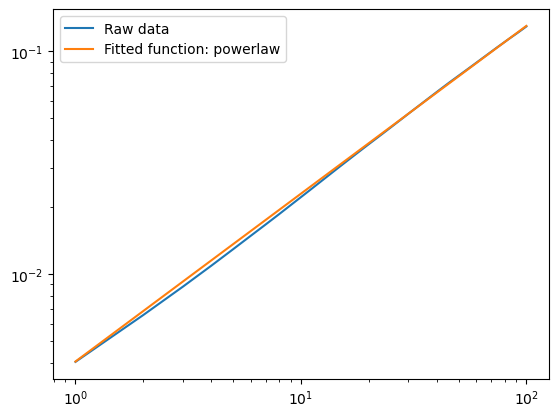

In [57]:
# Retrieve standard Hurst fit object for specific 'STOCK'
tsla_generalized_fit = sign_imbalance_fit_objects[('TSLA', 'generalized', 'signed_imbalance')]
tsla_generalized_fit.powerlaw.plot_fit()

### 3.2. Signed Volume imbalance long memory

In [58]:
# Linear ACF
volume_imbalance_linear_acf_filename = f"{acf_data_dir}/mo_volume_imbalance_linear_acfs.pkl"
volume_imbalance_linear_acfs = compute_acfs(filename=volume_imbalance_linear_acf_filename, data=volume_imbalance, option='linear')
print(volume_imbalance_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


In [59]:
# Nonlinear ACF
volume_imbalance_nonlinear_acf_filename = f"{acf_data_dir}/mo_volume_imbalance_nonlinear_acfs.pkl"
volume_imbalance_nonlinear_acfs = compute_acfs(filename=volume_imbalance_nonlinear_acf_filename, data=volume_imbalance, option='nonlinear')
print(volume_imbalance_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


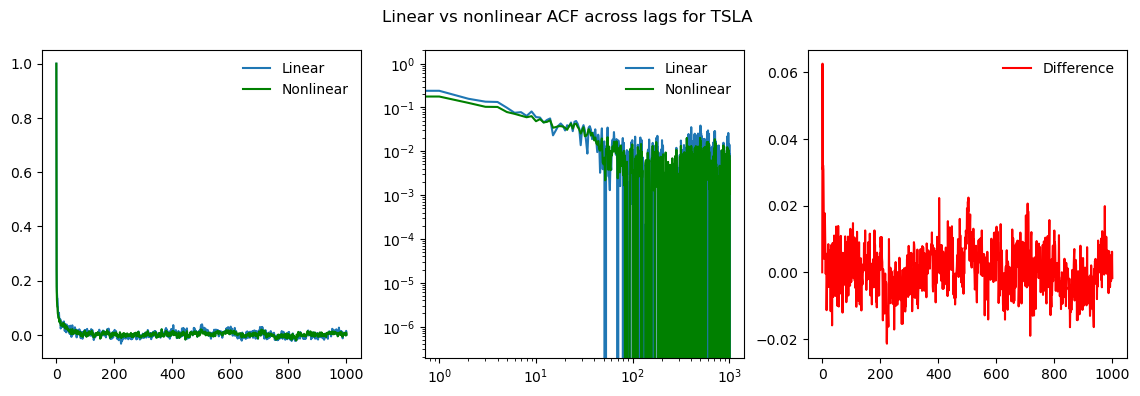

TSLA Max difference: 0.06258793533837562


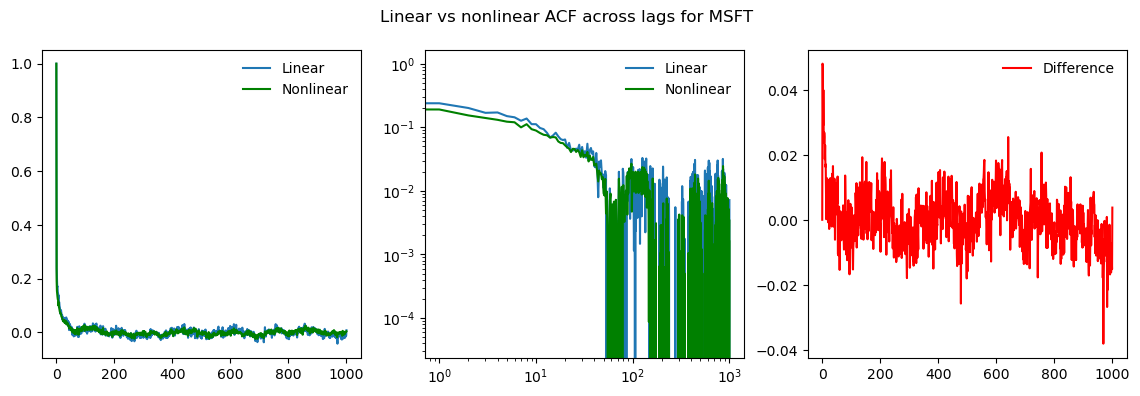

MSFT Max difference: 0.04803054241912216


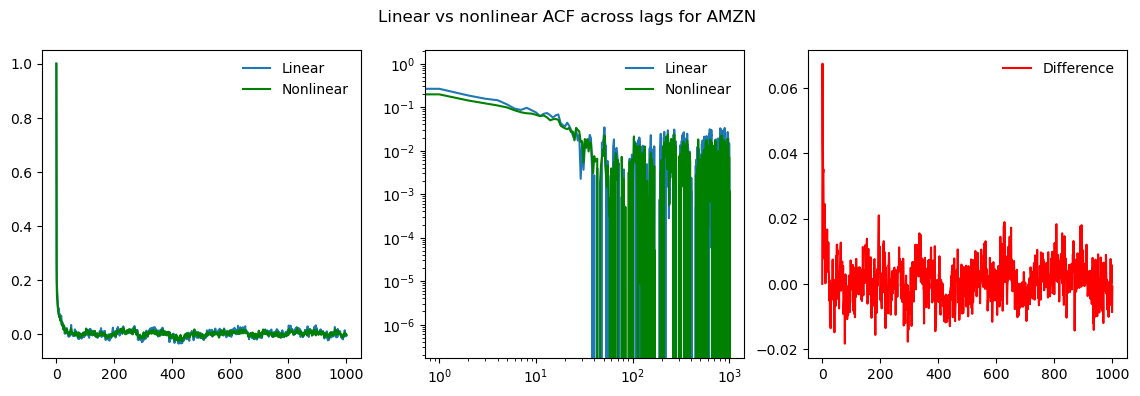

AMZN Max difference: 0.06744729854770515


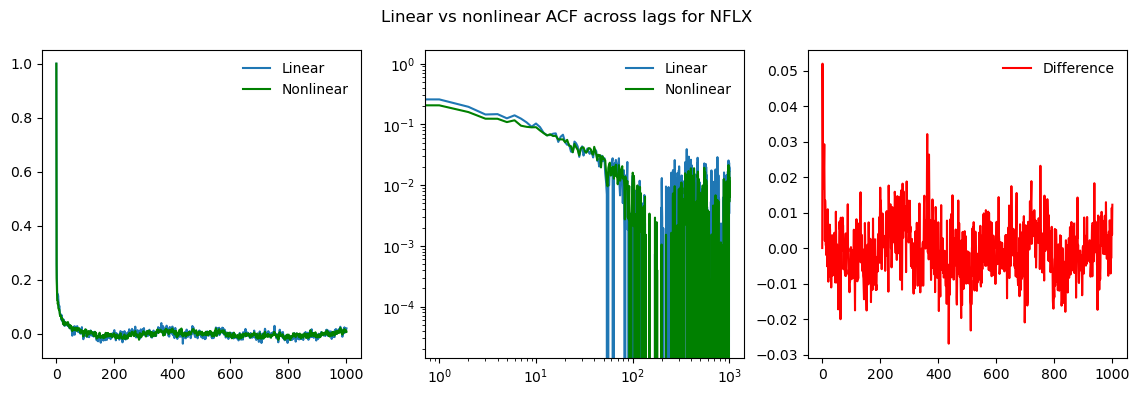

NFLX Max difference: 0.05192795917511439


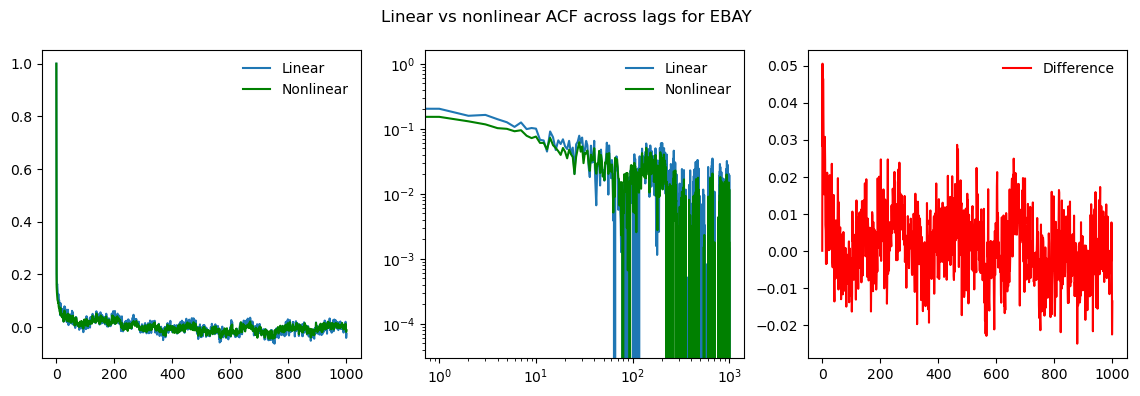

EBAY Max difference: 0.05050714487624314


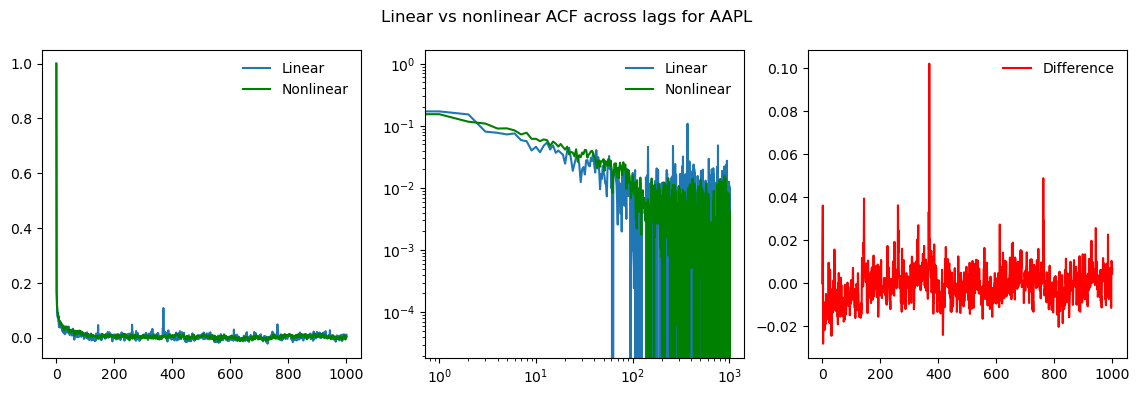

AAPL Max difference: 0.10199851445295897


In [60]:
for stock_name in volume_imbalance_linear_acfs.keys():
    plot_acf_difference(stock_name, volume_imbalance_linear_acfs, volume_imbalance_nonlinear_acfs)

#### 3.2.1. Fit power law to ACF

In [61]:
# Load the pre-computed ACFs
volume_imbalance_acf_values = {}

for stock, data in volume_imbalance_nonlinear_acfs.items():
    volume_imbalance_acf_values[stock] = construct_xy(data, stock)

In [62]:
# Using signs_imbalance_nonlinear_acfs
volume_imbalance_fit_results_list = []
volume_imbalance_fit_objects = {}  # Dictionary to store fit objects

for stock, data in volume_imbalance_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        volume_imbalance_fit_results_list.append(fit_dict)
        volume_imbalance_fit_objects[stock] = fit_obj  # Store the fit object

volume_imbalance_fit_results = pd.DataFrame(volume_imbalance_fit_results_list)
display(volume_imbalance_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.9206371...",10,11.0,0.401615,-9925.452514,392.922505,0.439881,-1.101937,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 3.0553983...",10,11.0,0.559031,-9343.591430,137.798963,0.515123,-1.383499,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 2.7997330...",10,11.0,0.396569,-9526.807041,192.154991,0.326018,-1.486938,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 2.8746412...",10,11.0,0.585267,-9310.943439,117.700930,0.510880,-1.361303,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -1.179844...",10,11.0,0.438951,-7927.883100,168.358242,0.098984,1.328017,EBAY


In [63]:
print(volume_imbalance_fit_objects.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'AAPL'])


In [64]:
avg_alpha = volume_imbalance_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.8124085595268785


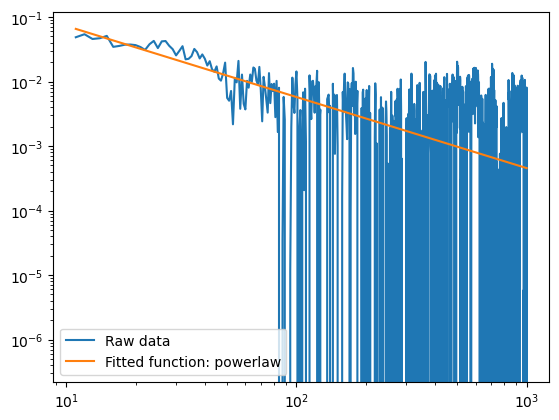

In [65]:
tsla_acf_fit = volume_imbalance_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

#### 3.2.2. Volume Imbalance Hurst Exponents

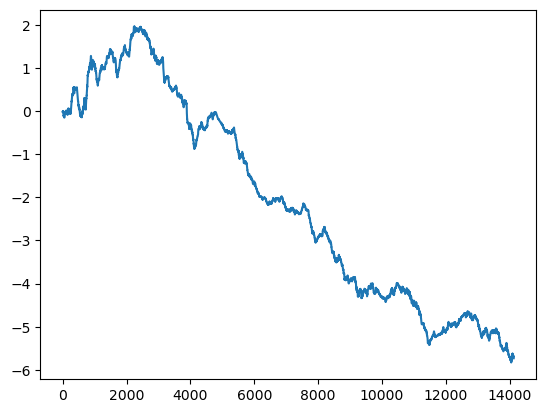

In [66]:
# Compute cumsum of order sign imbalance
cumsum_volume_imbalance = {
 'TSLA': tsla_aggregate_orderflow['volume_imbalance'].cumsum(),
 'MSFT': msft_aggregate_orderflow['volume_imbalance'].cumsum(),
 'AMZN': amzn_aggregate_orderflow['volume_imbalance'].cumsum(),
 'NFLX': nflx_aggregate_orderflow['volume_imbalance'].cumsum(),
 'EBAY': ebay_aggregate_orderflow['volume_imbalance'].cumsum(),
 'AAPL': appl_aggregate_orderflow['volume_imbalance'].cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
#cumsum_volume_imbalance = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_volume_imbalance.items()}
tsla_cumsum_volume_imbalance = tsla_aggregate_orderflow['volume_imbalance'].cumsum()
x = list(range(1, len(tsla_cumsum_volume_imbalance)+1))
plt.plot(x, tsla_cumsum_volume_imbalance)
plt.grid(False)
plt.show()

##### Standard Hurst

In [67]:
# Standard Hurst
method = 'standard'
volume_imbalance_fit_results_list = []
voliume_imbalance_fit_objects = {}

for stock, data in cumsum_volume_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('volume_imbalance', stock, data, method=method)
    if fit_dict:
        volume_imbalance_fit_results_list.append(fit_dict)
        voliume_imbalance_fit_objects[(stock, method, 'volume_imbalance')] = fit

volume_imbalance_std_hurst_fit_results = pd.DataFrame(volume_imbalance_fit_results_list)
display(volume_imbalance_std_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0085139...",1,1.0,0.025641,-1335.002363,2.307888,0.995579,0.667596,TSLA,volume_imbalance
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0072396...",1,1.0,0.027523,-1282.721290,2.705562,0.996588,0.688502,MSFT,volume_imbalance
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0112671...",1,1.0,0.056075,-1178.255649,3.599643,0.994299,0.625037,AMZN,volume_imbalance
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0085829...",1,1.0,0.035714,-1271.525556,2.102413,0.996499,0.694253,NFLX,volume_imbalance
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0114273...",1,2.0,0.044118,-711.074120,1.731428,0.996765,0.731810,EBAY,volume_imbalance


In [68]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = volume_imbalance_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.6822767980344583


##### Generalized Hurst

In [69]:
# Generalized Hurst
method = 'generalized'
volume_imbalance_fit_results_list = []
volume_imbalance_fit_objects = {}

for stock, data in cumsum_volume_imbalance.items():
    fit_dict, fit = compute_hurst_exponent('volume_imbalance', stock, data, method=method)
    if fit_dict:
        volume_imbalance_fit_results_list.append(fit_dict)
        volume_imbalance_fit_objects[(stock, method, 'volume_imbalance')] = fit

volume_imbalance_gen_hurst_fit_results = pd.DataFrame(volume_imbalance_fit_results_list)
display(volume_imbalance_gen_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0058695...",1,1.0,0.017094,-1842.729392,0.691610,0.999906,0.693026,TSLA,volume_imbalance
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0052349...",1,1.0,0.027523,-1471.362072,2.521306,0.999032,0.706024,MSFT,volume_imbalance
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0083222...",1,1.0,0.028037,-1395.666008,2.576095,0.998791,0.637694,AMZN,volume_imbalance
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0059157...",1,1.0,0.017857,-1571.314660,1.529223,0.999619,0.722758,NFLX,volume_imbalance
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0091361...",1,2.0,0.029412,-900.647832,1.089332,0.999668,0.724755,EBAY,volume_imbalance


In [70]:
# Generalized Hurst statistic across stocks
min_hurst_gen = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = volume_imbalance_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.6376940908891293
Max Generalized Hurst: 0.7448091947093135
Average Generalized Hurst: 0.7048443770411668
Standard_dev Generalized Hurst: 0.037322146841372375


In [71]:
display(volume_imbalance_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'volume_imbalance'), ('MSFT', 'generalized', 'volume_imbalance'), ('AMZN', 'generalized', 'volume_imbalance'), ('NFLX', 'generalized', 'volume_imbalance'), ('EBAY', 'generalized', 'volume_imbalance'), ('AAPL', 'generalized', 'volume_imbalance')])

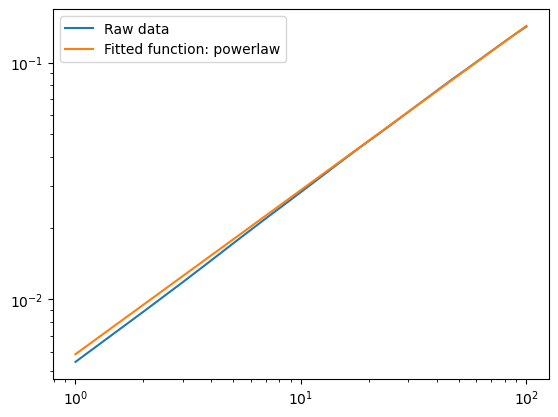

In [72]:
# Retrieve standard Hurst fit object for specific 'STOCK'
tsla_generalized_fit = volume_imbalance_fit_objects[('TSLA', 'generalized', 'volume_imbalance')]
tsla_generalized_fit.powerlaw.plot_fit()